<a href="https://colab.research.google.com/github/Lasal0425/ML_Coursework_Breast_Cancer_Detection/blob/Notebook-02/Notebook02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load the classification dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursework/cancer_classification_dataset.csv')
print("Dataset loaded successfully with shape:", df.shape)
print(df.head())

Dataset loaded successfully with shape: (4024, 16)
   Month_of_Birth   Age     Sex T_Stage N_Stage 6th_Stage  \
0              12  68.0  Female      T1      N1       IIA   
1              12  50.0  Female      T2      N2      IIIA   
2              11  58.0  Female      T3      N3      IIIC   
3               3  58.0  Female      T1      N1       IIA   
4               1  47.0  Female      T2      N1       IIB   

              Differentiated  Grade   A_Stage  Tumor_Size Estrogen_Status  \
0      Poorly differentiated      3  Regional         4.0        Positive   
1  Moderately differentiated      2  Regional        35.0        Positive   
2  Moderately differentiated      2  Regional        63.0        Positive   
3      Poorly differentiated      3  Regional        18.0        Positive   
4      Poorly differentiated      3  Regional        41.0        Positive   

  Progesterone_Status  Regional_Node_Examined  Reginol_Node_Positive  \
0            Positive                    24.0  

In [4]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
Month_of_Birth            0
Age                       0
Sex                       0
T_Stage                   0
N_Stage                   0
6th_Stage                 0
Differentiated            0
Grade                     0
A_Stage                   0
Tumor_Size                0
Estrogen_Status           0
Progesterone_Status       0
Regional_Node_Examined    0
Reginol_Node_Positive     0
Survival_Months           0
Mortality_Status          0
dtype: int64


In [5]:
# Split the data into features and target
X = df.drop('Mortality_Status', axis=1)
y = df['Mortality_Status']

In [6]:
# Check if target is categorical and convert if needed
if y.dtype == 'object':
    print("\nConverting categorical target to numeric...")
    y = y.map(lambda x: 0 if x == 'Alive' else 1)


Converting categorical target to numeric...


In [7]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['Sex', 'T_Stage', 'N_Stage', '6th_Stage', 'Differentiated', 'A_Stage', 'Estrogen_Status', 'Progesterone_Status']
Numerical columns: ['Month_of_Birth', 'Age', 'Grade', 'Tumor_Size', 'Regional_Node_Examined', 'Reginol_Node_Positive', 'Survival_Months']


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData split into training and testing sets")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Data split into training and testing sets
Training set: 3219 samples
Testing set: 805 samples


In [10]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

In [15]:
# Define a function to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.array([0.5 for _ in range(len(y_test))])

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(report)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model, accuracy, auc, conf_matrix, report


========== Naive Bayes Classifier ==========
Performing grid search for Naive Bayes...
Best parameters: {'classifier__var_smoothing': np.float64(0.1)}
Best cross-validation score: 0.8288

--- Naive Bayes Results ---
Accuracy: 0.8174
AUC: 0.7331

Confusion Matrix:
[[611  69]
 [ 78  47]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       680
           1       0.41      0.38      0.39       125

    accuracy                           0.82       805
   macro avg       0.65      0.64      0.64       805
weighted avg       0.81      0.82      0.81       805



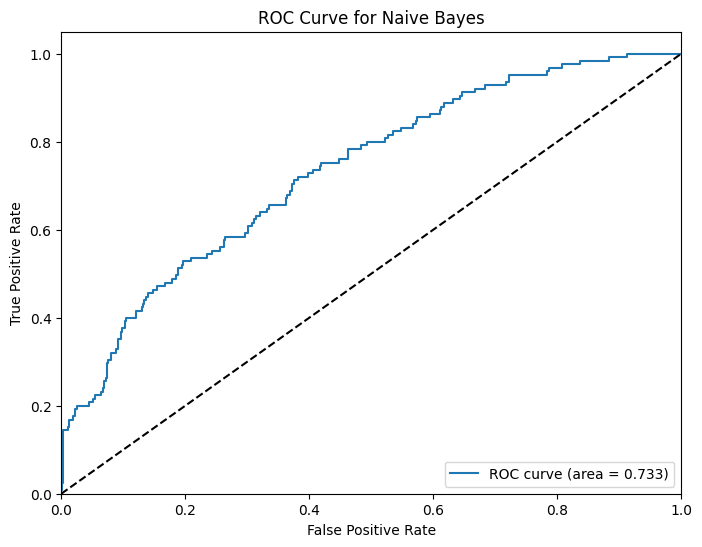

In [17]:
# 1. Naive Bayes Classifier
print("\n========== Naive Bayes Classifier ==========")

# Create a pipeline with preprocessing and Naive Bayes
naive_bayes_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Define parameters for Naive Bayes
# For Gaussian Naive Bayes, we can try different var_smoothing values
nb_param_grid = {
    'classifier__var_smoothing': np.logspace(-10, -1, 10)
}

# Create grid search
naive_bayes_grid = GridSearchCV(
    naive_bayes_pipeline,
    nb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Naive Bayes...")
naive_bayes_grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {naive_bayes_grid.best_params_}")
print(f"Best cross-validation score: {naive_bayes_grid.best_score_:.4f}")

# Evaluate the best model
best_nb = naive_bayes_grid.best_estimator_
nb_model, nb_acc, nb_auc, nb_cm, nb_report = evaluate_model(best_nb, X_train, X_test, y_train, y_test, "Naive Bayes")


========== Logistic Regression ==========
Performing grid search for Logistic Regression...
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation score: 0.8947

--- Logistic Regression Results ---
Accuracy: 0.8894
AUC: 0.8295

Confusion Matrix:
[[664  16]
 [ 73  52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       680
           1       0.76      0.42      0.54       125

    accuracy                           0.89       805
   macro avg       0.83      0.70      0.74       805
weighted avg       0.88      0.89      0.88       805



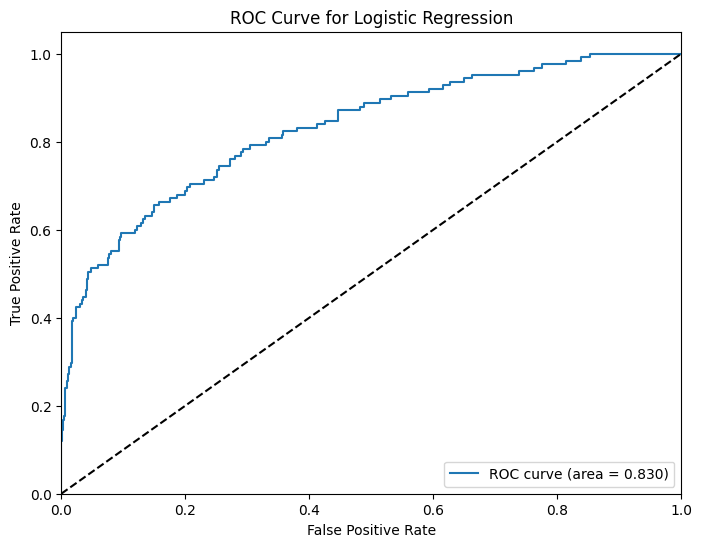

In [18]:
# 2. Logistic Regression
print("\n========== Logistic Regression ==========")

# Create a pipeline with preprocessing and Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Define parameters for Logistic Regression
logreg_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', 'l1', 'elasticnet', None],
    'classifier__solver': ['lbfgs', 'newton-cg', 'liblinear']
}

# Create grid search
logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

# Update the param grid to handle solver incompatibilities
logreg_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2', None],
    'classifier__solver': ['lbfgs', 'newton-cg']
}

logreg_param_grid_liblinear = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Use a more compatible parameter grid
logreg_grid = GridSearchCV(
    logreg_pipeline,
    logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Logistic Regression...")
logreg_grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {logreg_grid.best_params_}")
print(f"Best cross-validation score: {logreg_grid.best_score_:.4f}")

# Evaluate the best model
best_logreg = logreg_grid.best_estimator_
logreg_model, logreg_acc, logreg_auc, logreg_cm, logreg_report = evaluate_model(best_logreg, X_train, X_test, y_train, y_test, "Logistic Regression")


========== K-Nearest Neighbors ==========
Performing grid search for KNN...
Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best cross-validation score: 0.8792

--- K-Nearest Neighbors Results ---
Accuracy: 0.8696
AUC: 0.7698

Confusion Matrix:
[[669  11]
 [ 94  31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       680
           1       0.74      0.25      0.37       125

    accuracy                           0.87       805
   macro avg       0.81      0.62      0.65       805
weighted avg       0.86      0.87      0.84       805



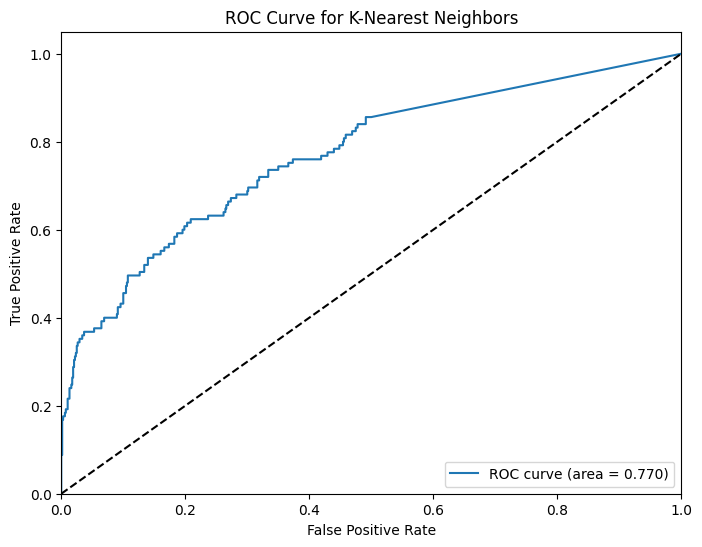


========== Model Comparison ==========


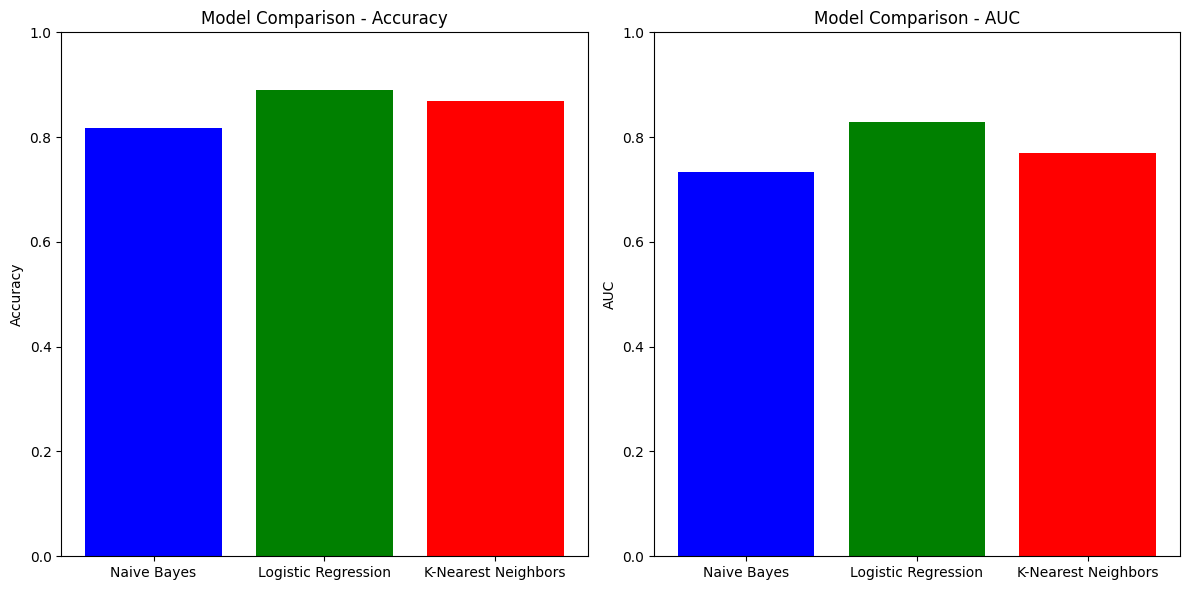

                 Model  Accuracy       AUC
1  Logistic Regression  0.889441  0.829506
2  K-Nearest Neighbors  0.869565  0.769788
0          Naive Bayes  0.817391  0.733118

Saving the best model: Logistic Regression
Best model saved successfully!


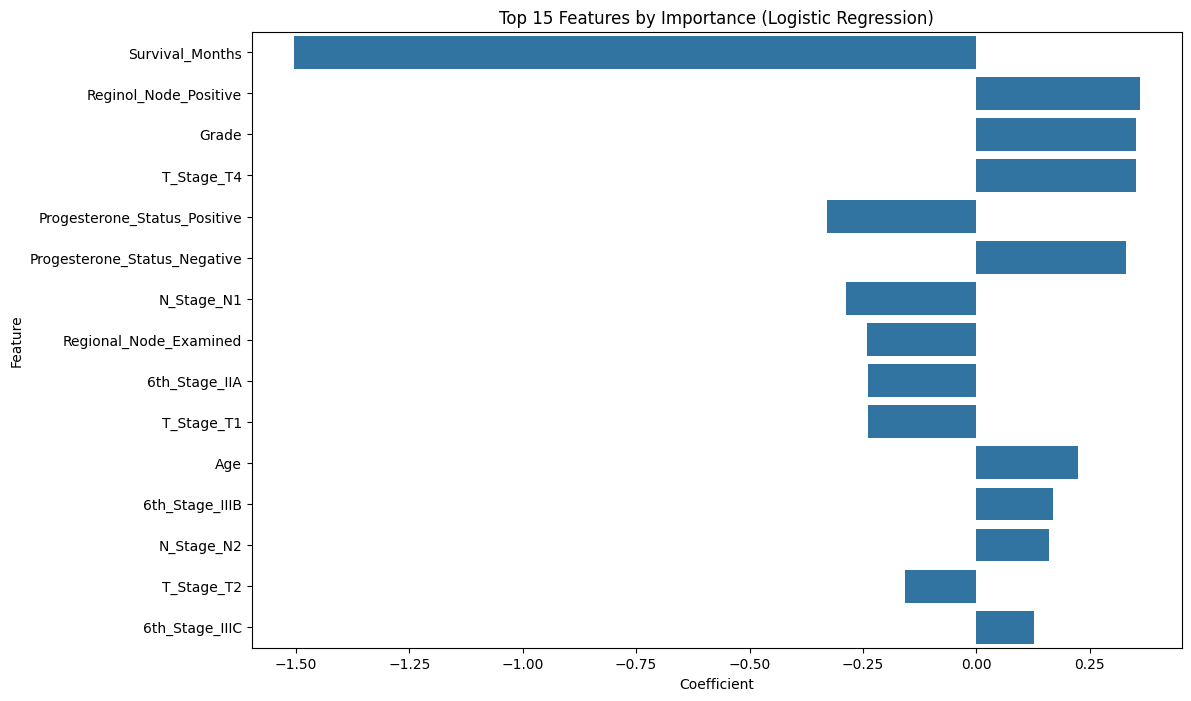


Top 15 features by importance:
                         Feature  Coefficient
6                Survival_Months    -1.503656
5          Reginol_Node_Positive     0.359564
2                          Grade     0.351969
12                    T_Stage_T4     0.351454
30  Progesterone_Status_Positive    -0.329167
29  Progesterone_Status_Negative     0.328938
13                    N_Stage_N1    -0.286625
4         Regional_Node_Examined    -0.241403
16                 6th_Stage_IIA    -0.238852
9                     T_Stage_T1    -0.238317
1                            Age     0.223675
19                6th_Stage_IIIB     0.168519
14                    N_Stage_N2     0.159001
10                    T_Stage_T2    -0.156513
20                6th_Stage_IIIC     0.127395


In [21]:
# 3. K-Nearest Neighbors
print("\n========== K-Nearest Neighbors ==========")

# Create a pipeline with preprocessing and KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define parameters for KNN
knn_param_grid = {
    'classifier__n_neighbors': list(range(1, 31, 2)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # only relevant for Minkowski metric
}

# Create grid search
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for KNN...")
knn_grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

# Evaluate the best model
best_knn = knn_grid.best_estimator_
knn_model, knn_acc, knn_auc, knn_cm, knn_report = evaluate_model(best_knn, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

# Compare the models
print("\n========== Model Comparison ==========")
models = ['Naive Bayes', 'Logistic Regression', 'K-Nearest Neighbors']
accuracies = [nb_acc, logreg_acc, knn_acc]
aucs = [nb_auc, logreg_auc, knn_auc]

# Create a bar plot to compare models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.bar(models, aucs, color=['blue', 'green', 'red'])
plt.title('Model Comparison - AUC')
plt.ylabel('AUC')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Detailed comparison table
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'AUC': aucs
})
print(comparison_df.sort_values('Accuracy', ascending=False))

# Save the best model
import joblib

# Save the best model (choose the one with the highest accuracy)
best_model_idx = accuracies.index(max(accuracies))
best_model_name = models[best_model_idx]
best_model = [nb_model, logreg_model, knn_model][best_model_idx]

print(f"\nSaving the best model: {best_model_name}")
joblib.dump(best_model, f'best_cancer_mortality_classifier.pkl')
print("Best model saved successfully!")

# Generate visualizations for feature importance (for Logistic Regression)
if hasattr(best_logreg.named_steps['classifier'], 'coef_'):
    # Get feature names after preprocessing
    cat_features = best_logreg.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
    all_features = numerical_cols + list(cat_features)

    # Get the coefficients
    coefficients = best_logreg.named_steps['classifier'].coef_[0]

    # Only include the first len(all_features) coefficients in case there are more
    if len(coefficients) > len(all_features):
        coefficients = coefficients[:len(all_features)]

    # Create a DataFrame for visualization
    coef_df = pd.DataFrame({'Feature': all_features[:len(coefficients)], 'Coefficient': coefficients})
    coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

    # Plot the top 15 features
    plt.figure(figsize=(12, 8))
    top_features = coef_df.head(15)
    sns.barplot(x='Coefficient', y='Feature', data=top_features)
    plt.title('Top 15 Features by Importance (Logistic Regression)')
    plt.show()

    print("\nTop 15 features by importance:")
    print(top_features)